In [1]:
#importing
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import keras
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

2024-07-22 15:16:02.631498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
closest_distances_all_data = []
weighted_distances_all_data = []
MLP_distances_all_data = []

Average Regular Distance (mm): 6.250160109822974
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 6.729316336445287
Median Weighted Distance (mm): 5.531065084035726


2024-07-22 15:16:04.251982: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-22 15:16:04.252750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-22 15:16:04.256594: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-07-22 15:16:04.256605: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ni-MS-7D75
2024-07-22 15:16:04.256609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ni-MS-7D75
2024-07-22 15:16:04.256738: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.6
2024-07-22 15:16:04.256754: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: Not found: could not fi

Average MLP Distance (mm): 0.6248935877578864
Median MLP Distance (mm): 0.5364250510012366


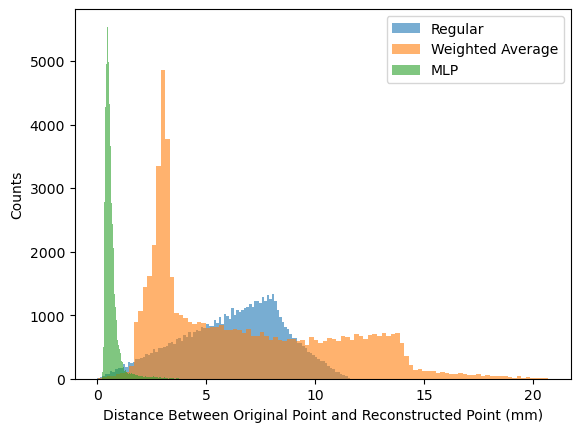

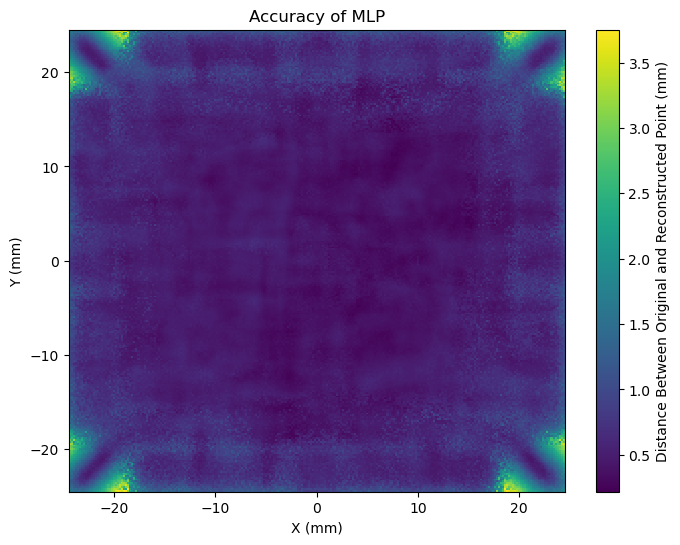

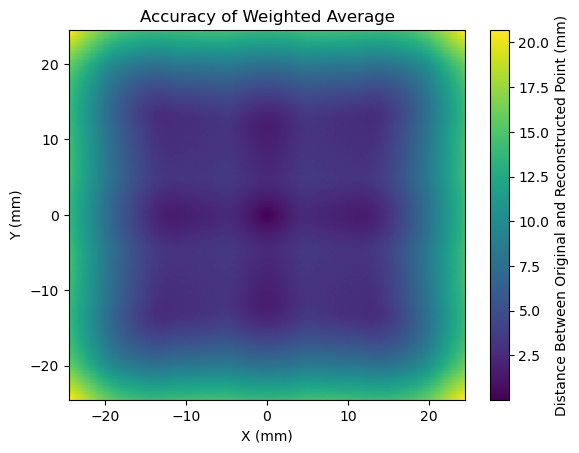

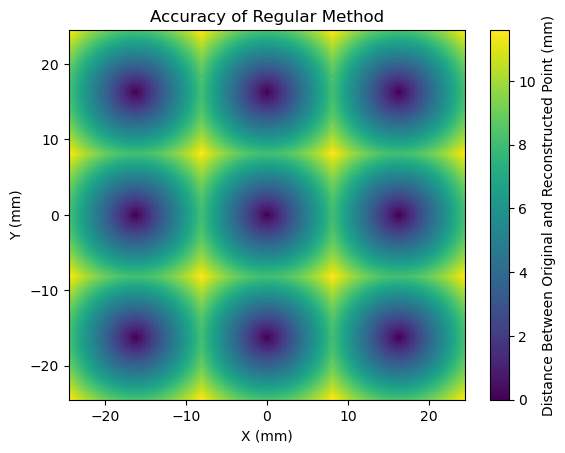

In [3]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_1mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.251391948378429
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 7.50531633863917
Median Weighted Distance (mm): 6.525859626115792
Average MLP Distance (mm): 0.680779398166009
Median MLP Distance (mm): 0.5692438229356597


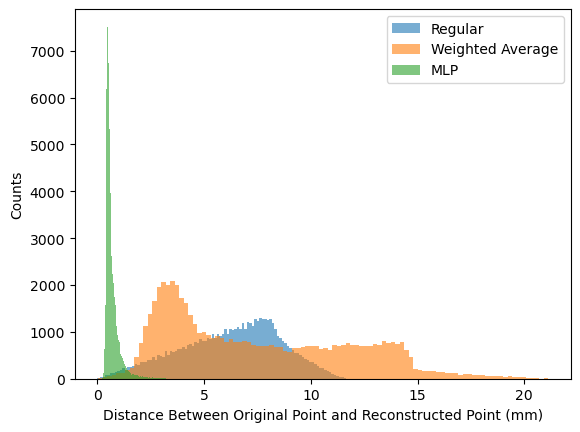

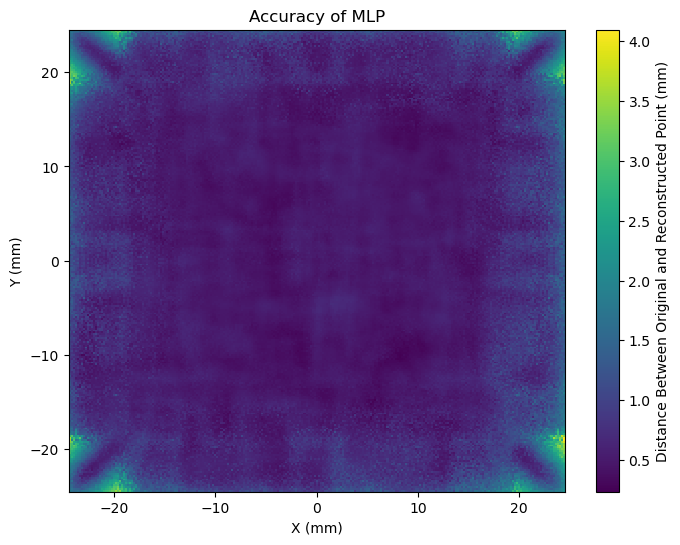

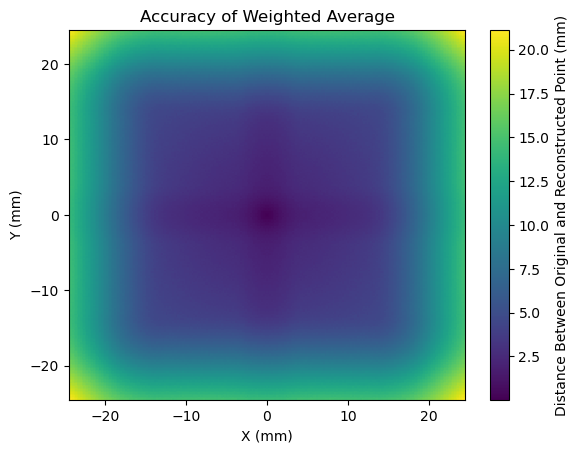

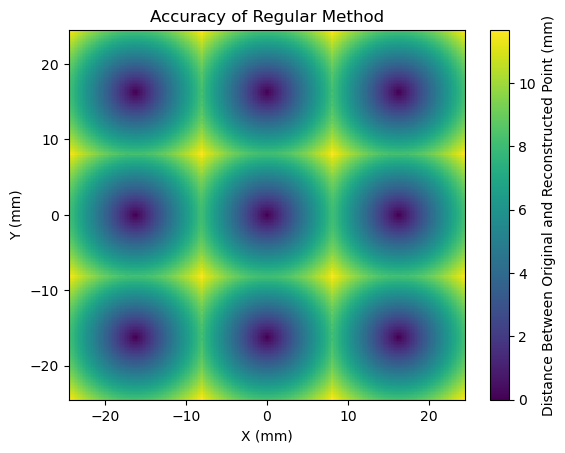

In [4]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_2mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.251959273904546
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 8.284013471528972
Median Weighted Distance (mm): 7.585194743737543
Average MLP Distance (mm): 0.6551748180960767
Median MLP Distance (mm): 0.5611969832136773


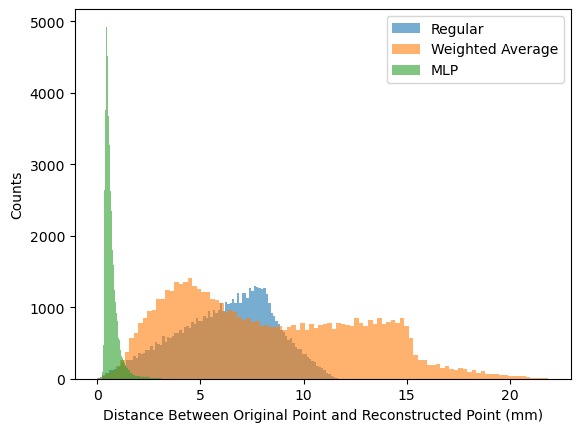

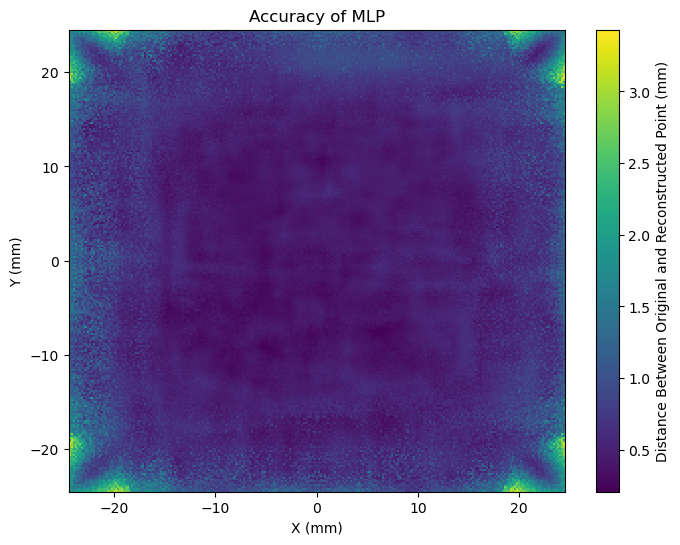

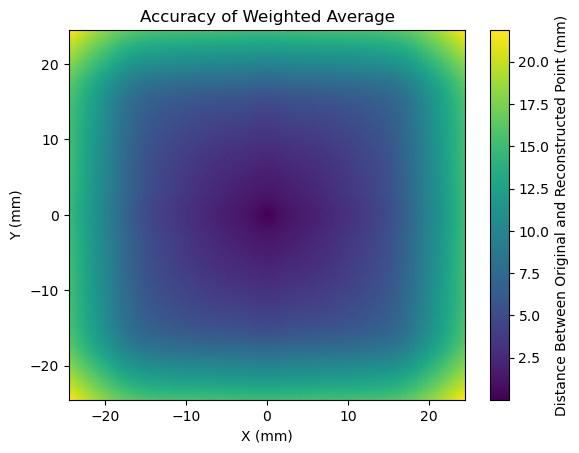

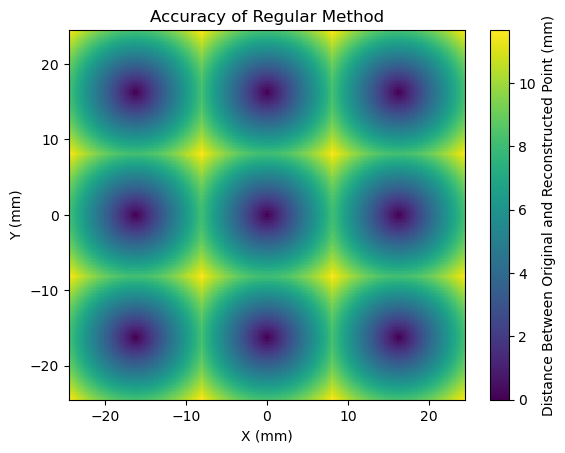

In [5]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_3mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.2528050076362
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 9.041568830092812
Median Weighted Distance (mm): 8.644247130184946
Average MLP Distance (mm): 0.6557798788910761
Median MLP Distance (mm): 0.5209435502162265


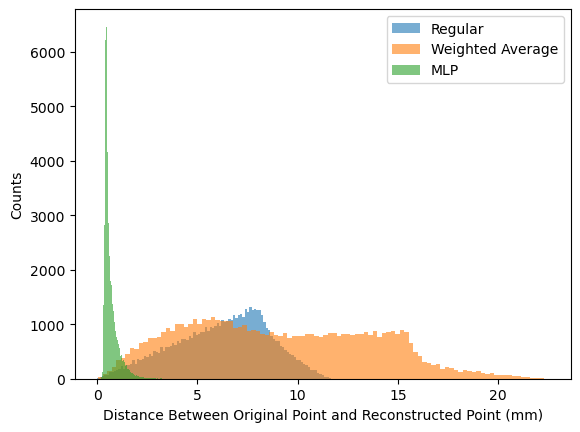

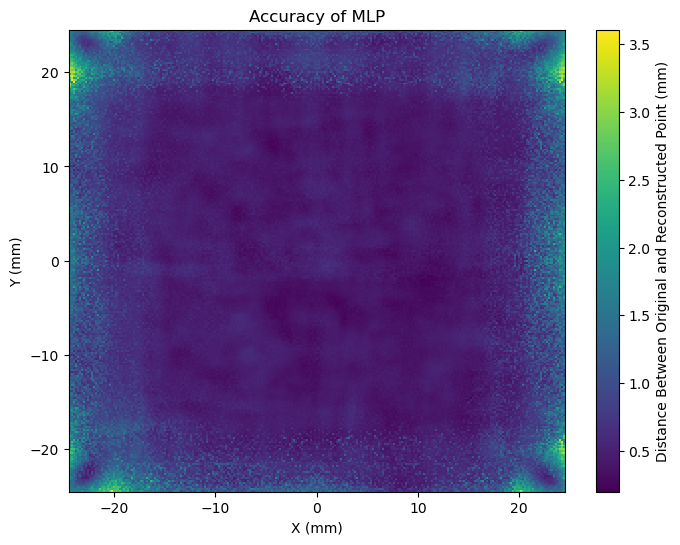

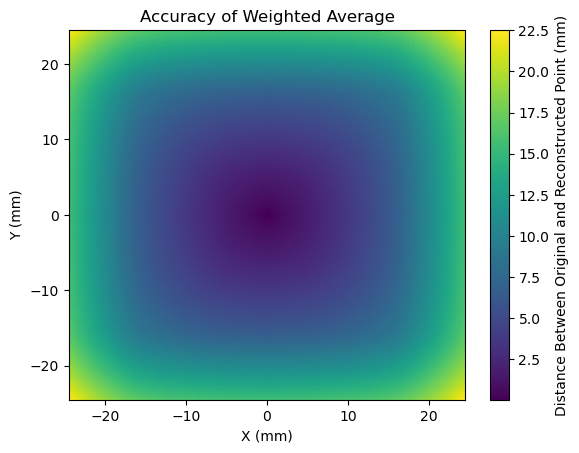

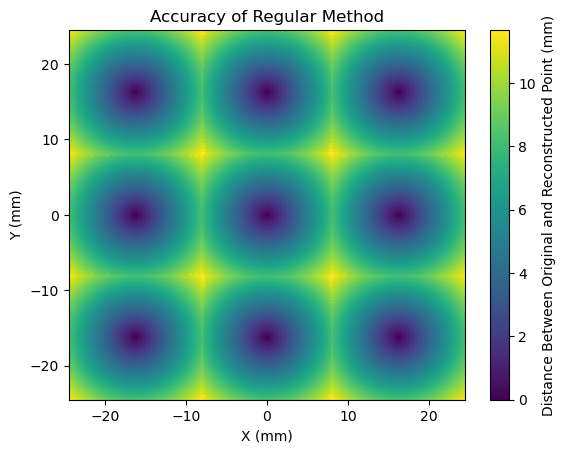

In [6]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_4mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.255960036848886
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 9.770682315852321
Median Weighted Distance (mm): 9.638136396315831
Average MLP Distance (mm): 0.6817774494755404
Median MLP Distance (mm): 0.5574584891634206


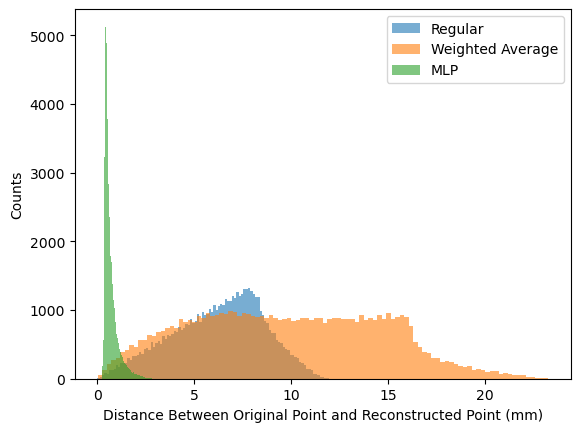

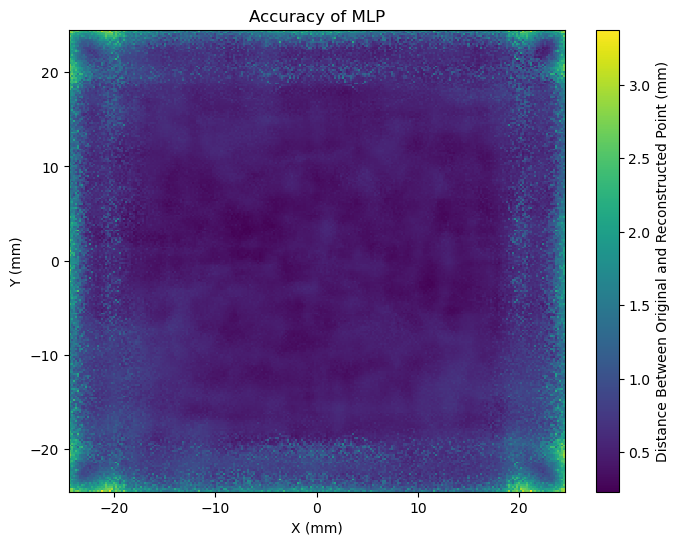

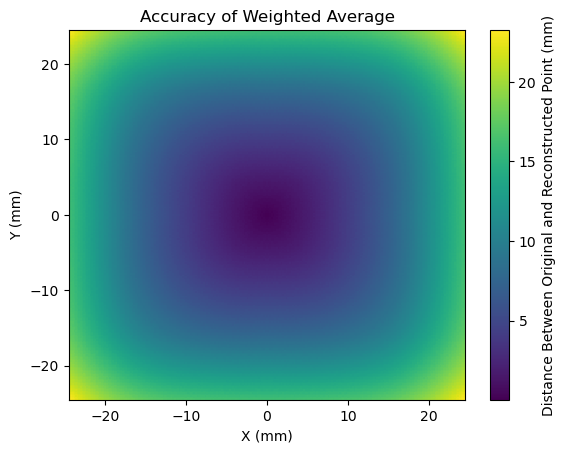

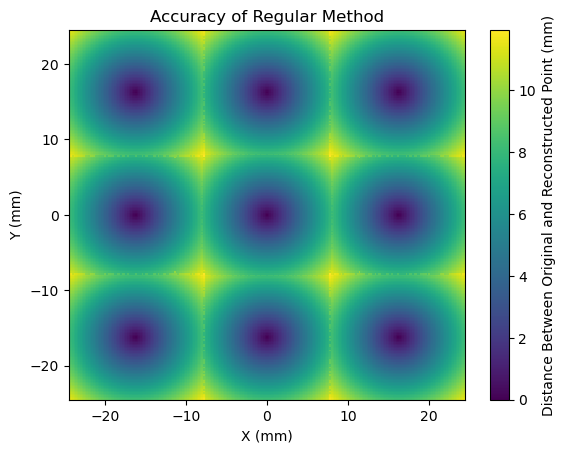

In [7]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_5mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.258930922522094
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 10.465979868388784
Median Weighted Distance (mm): 10.526581383275504
Average MLP Distance (mm): 0.7307972344736717
Median MLP Distance (mm): 0.5360071424446701


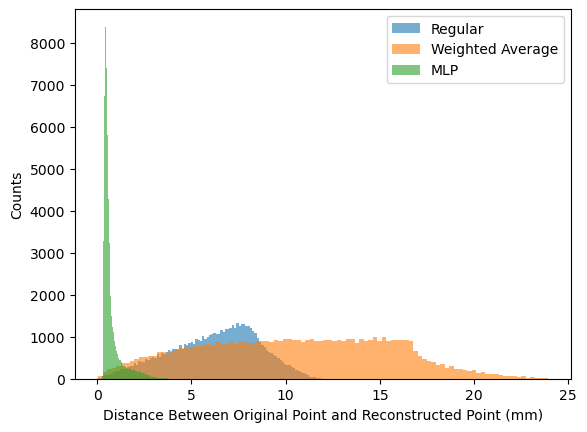

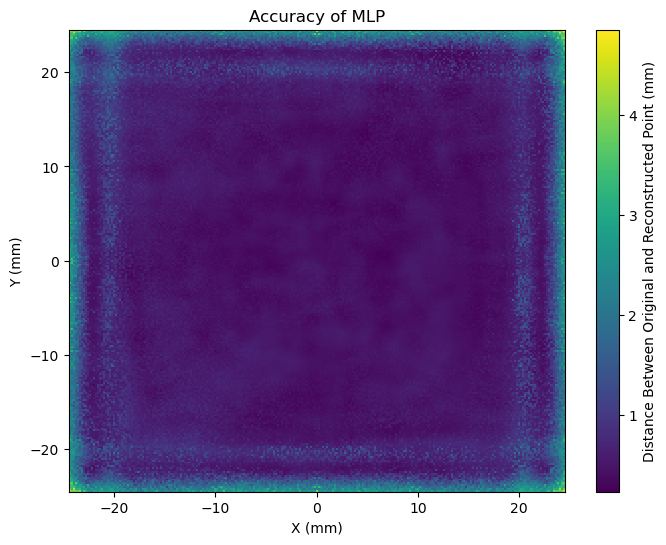

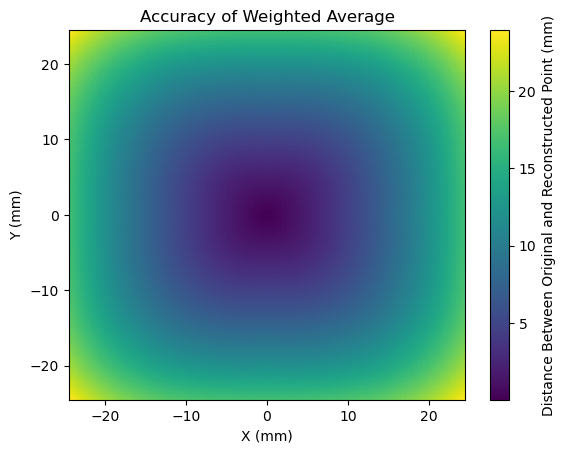

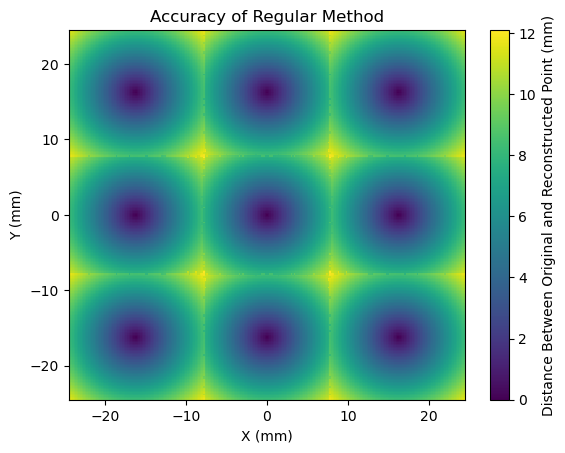

In [8]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_6mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.264210127080224
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 11.125156276435149
Median Weighted Distance (mm): 11.341674534575214
Average MLP Distance (mm): 0.709764718356719
Median MLP Distance (mm): 0.5654179670520756


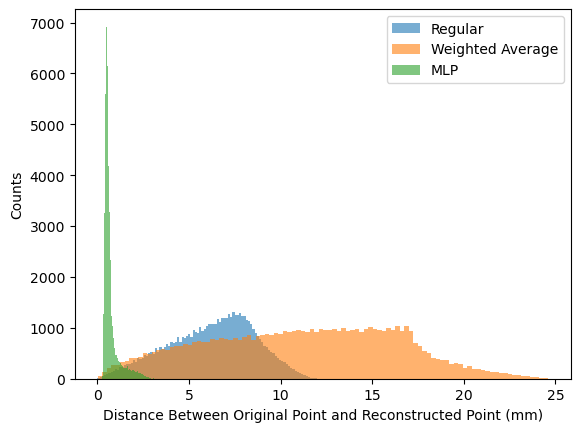

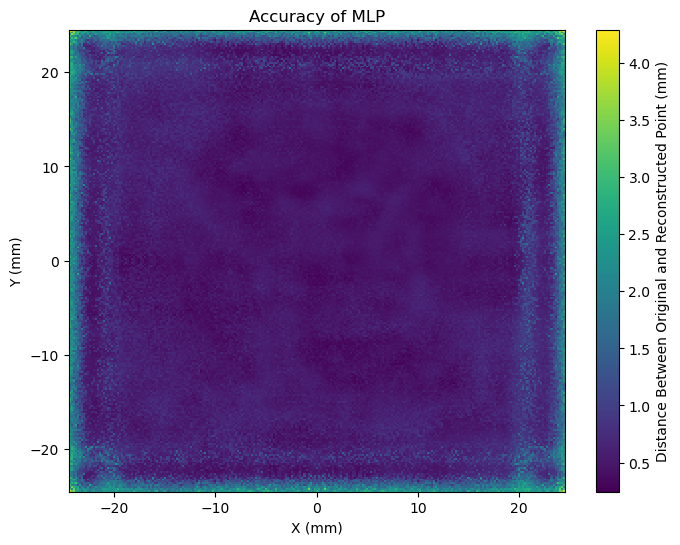

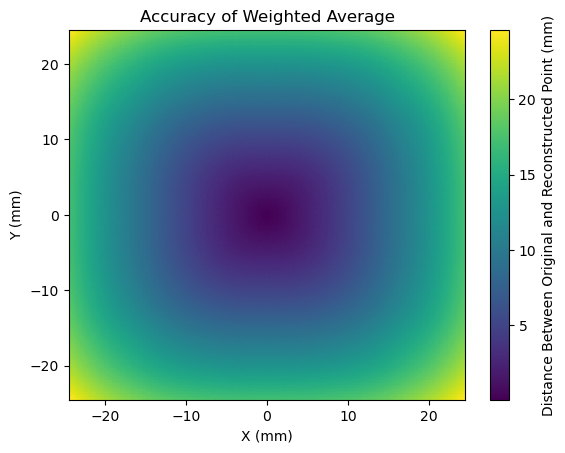

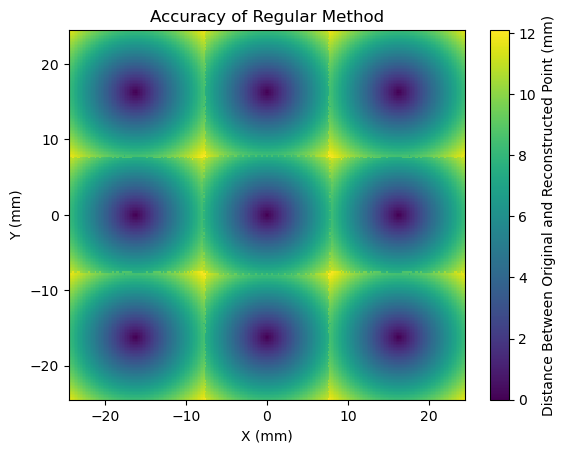

In [9]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_7mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.2710365230577985
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 11.74732138041681
Median Weighted Distance (mm): 12.07761420026663
Average MLP Distance (mm): 0.7059843522081619
Median MLP Distance (mm): 0.5791236666364996


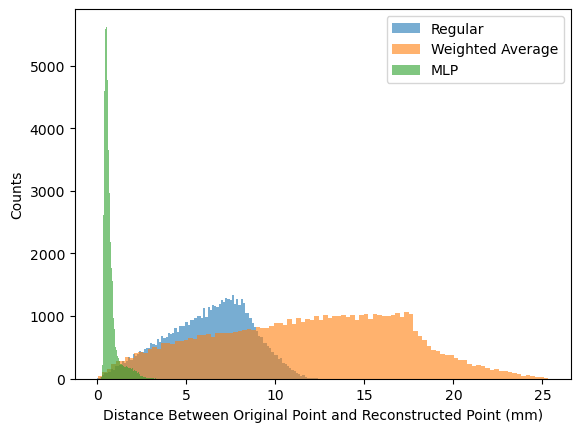

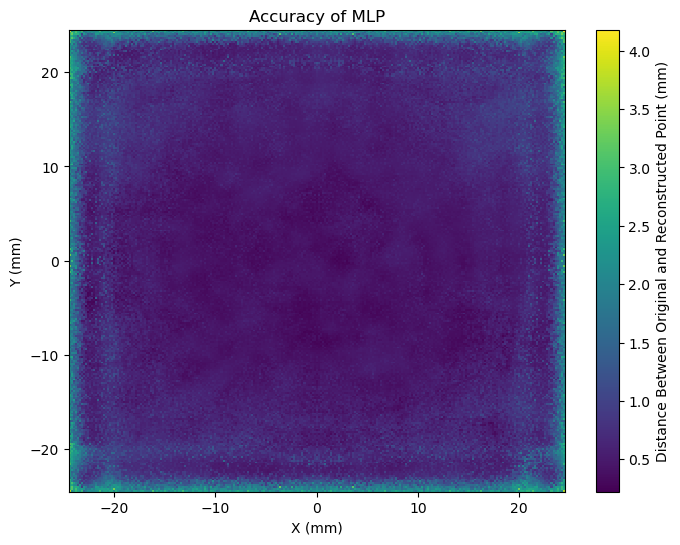

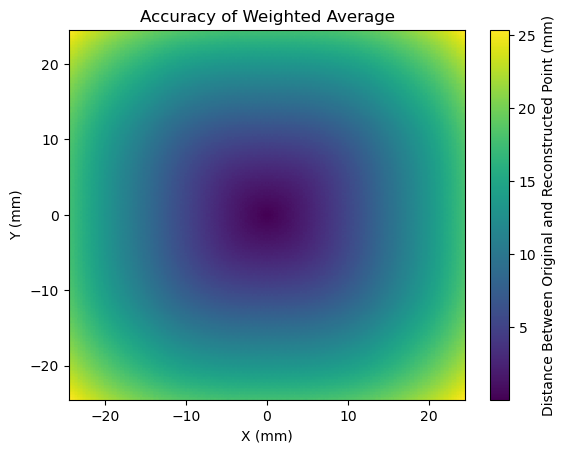

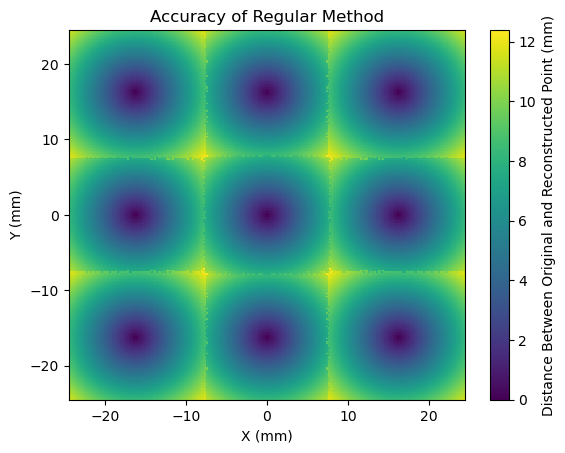

In [10]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_8mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.2822070635799445
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 12.333419378918244
Median Weighted Distance (mm): 12.741229064400224
Average MLP Distance (mm): 0.6361728155257914
Median MLP Distance (mm): 0.5358068597786173


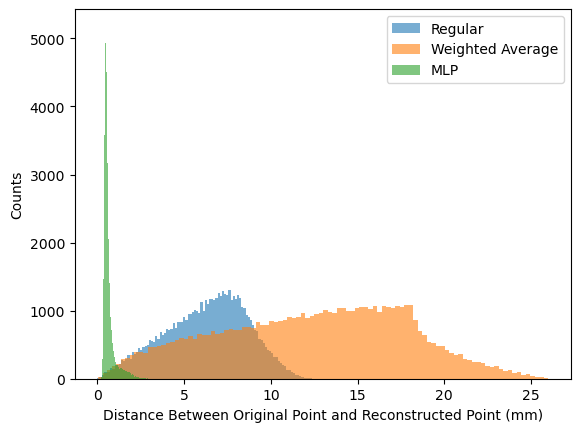

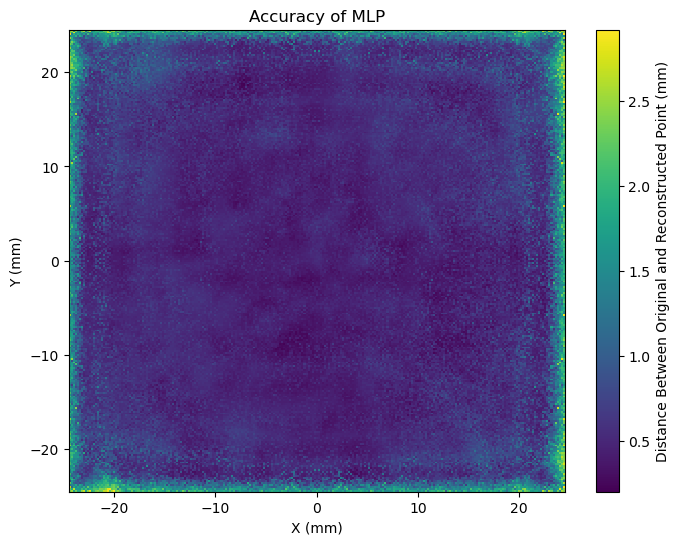

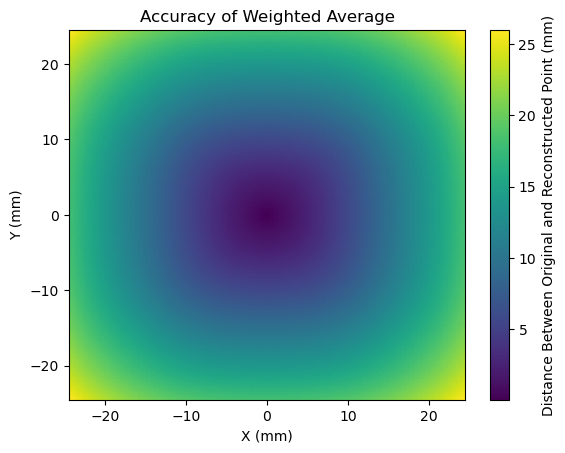

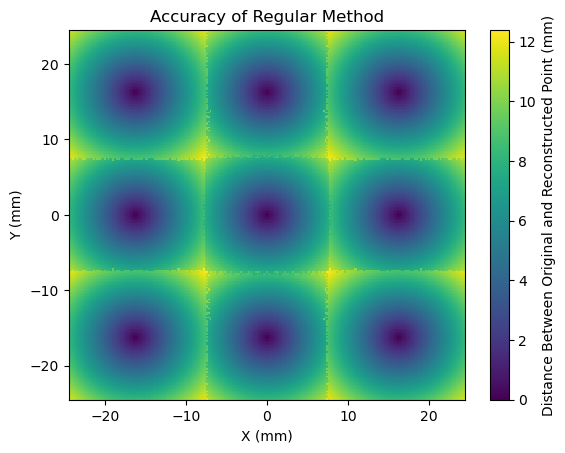

In [11]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_9mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.300611974265118
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 12.883299297493622
Median Weighted Distance (mm): 13.335840864446983
Average MLP Distance (mm): 0.6839690687504146
Median MLP Distance (mm): 0.6071365980107515


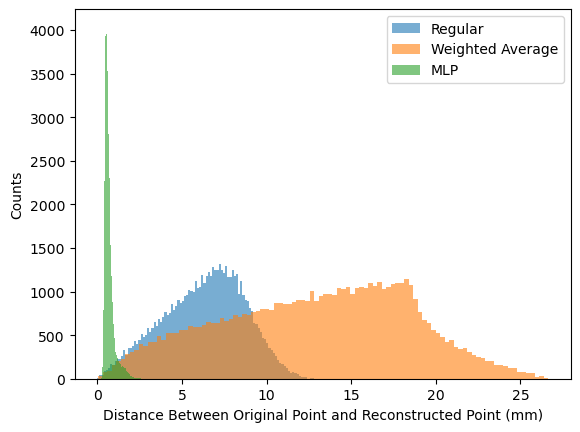

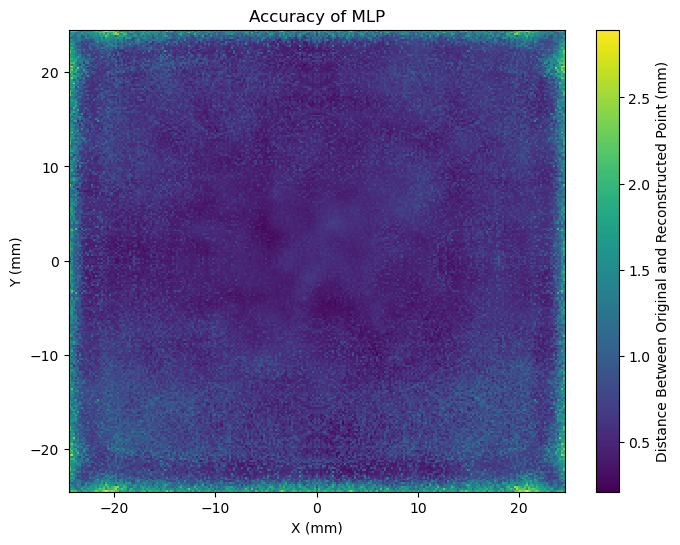

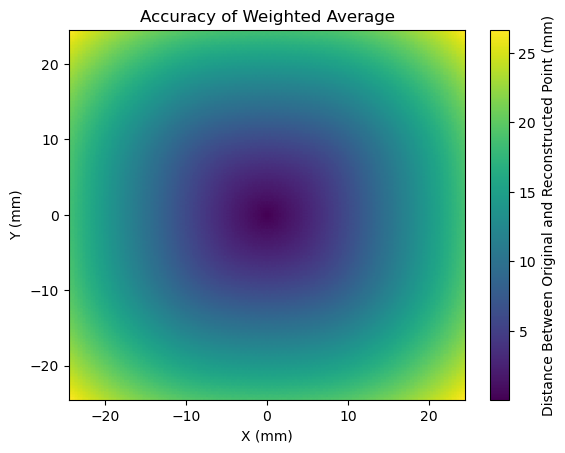

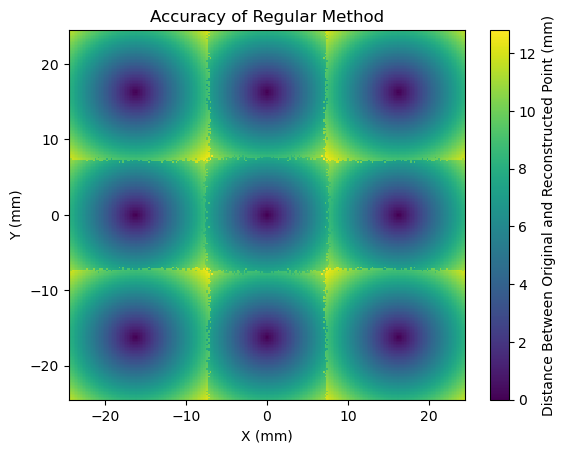

In [12]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_10mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.337936714167619
Median Regular Distance (mm): 6.514598989960933
Average Weighted Distance (mm): 13.398059204666437
Median Weighted Distance (mm): 13.884263128089795
Average MLP Distance (mm): 0.6973295251829837
Median MLP Distance (mm): 0.6355799620023483


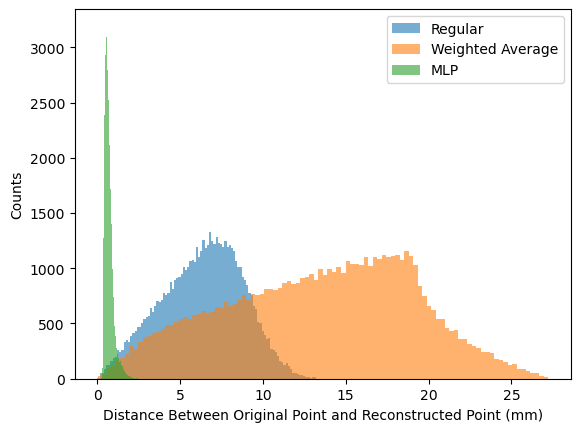

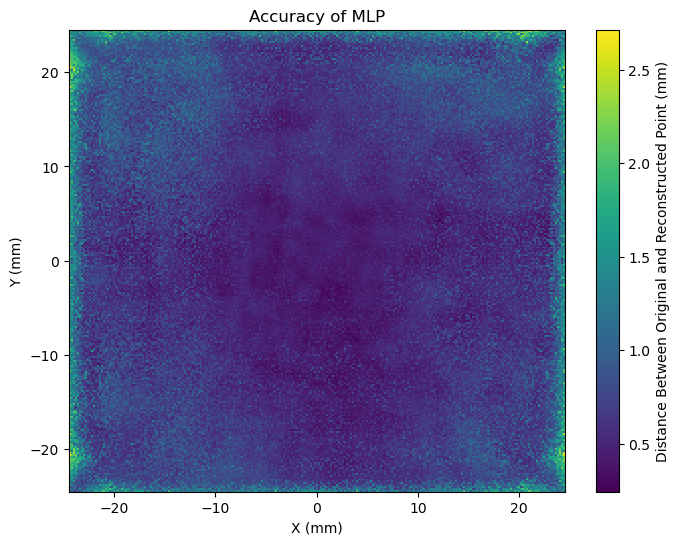

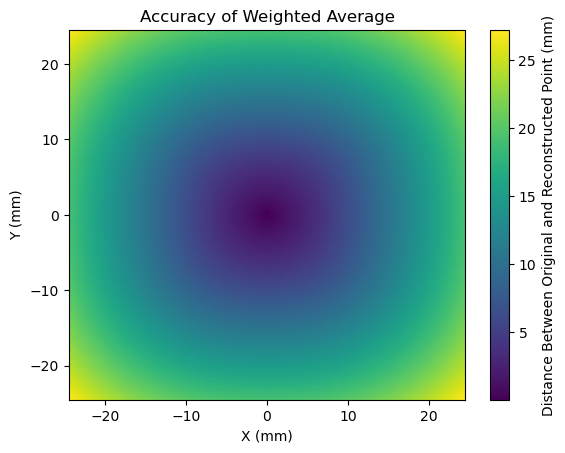

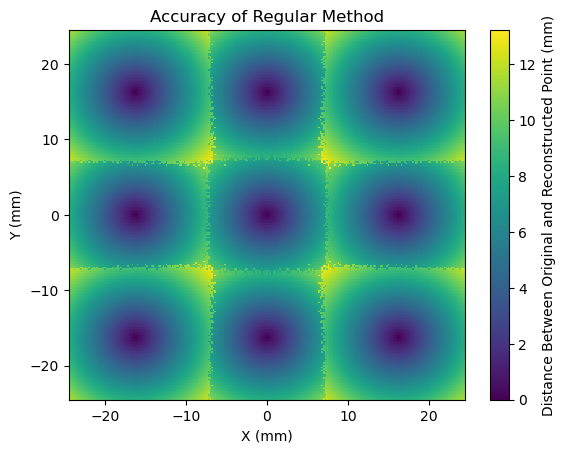

In [13]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_11mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.41467498351419
Median Regular Distance (mm): 6.518051856191389
Average Weighted Distance (mm): 13.876861128565995
Median Weighted Distance (mm): 14.376592622657935
Average MLP Distance (mm): 0.6698294223165044
Median MLP Distance (mm): 0.6092732840033949


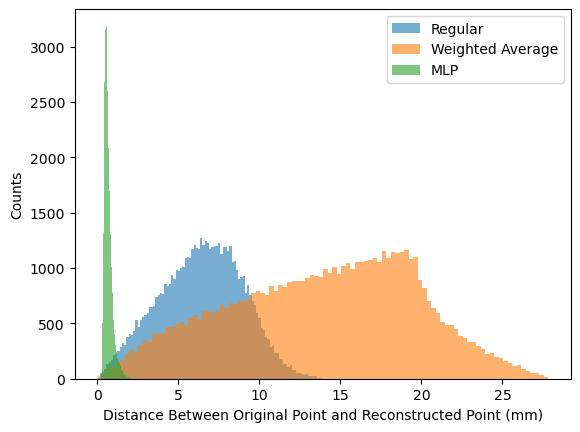

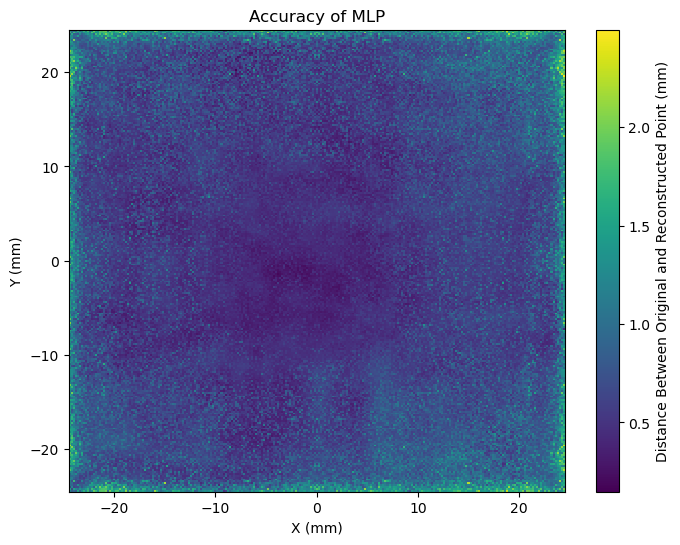

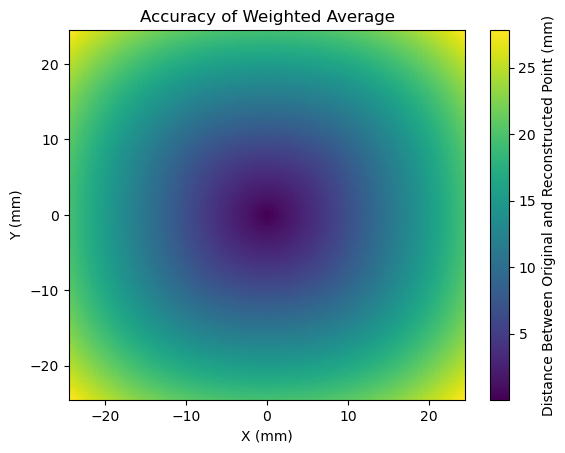

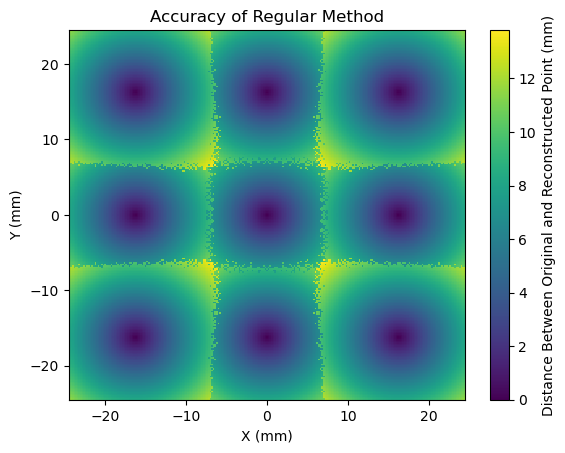

In [14]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_12mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.522750540488566
Median Regular Distance (mm): 6.5547692560455575
Average Weighted Distance (mm): 14.32220771153032
Median Weighted Distance (mm): 14.846380512874857
Average MLP Distance (mm): 0.6886458548738728
Median MLP Distance (mm): 0.626512101380903


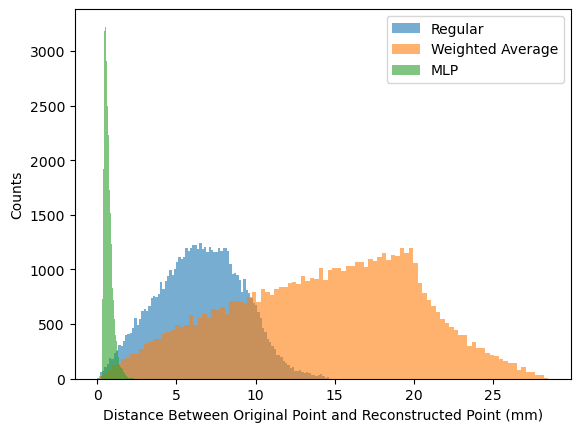

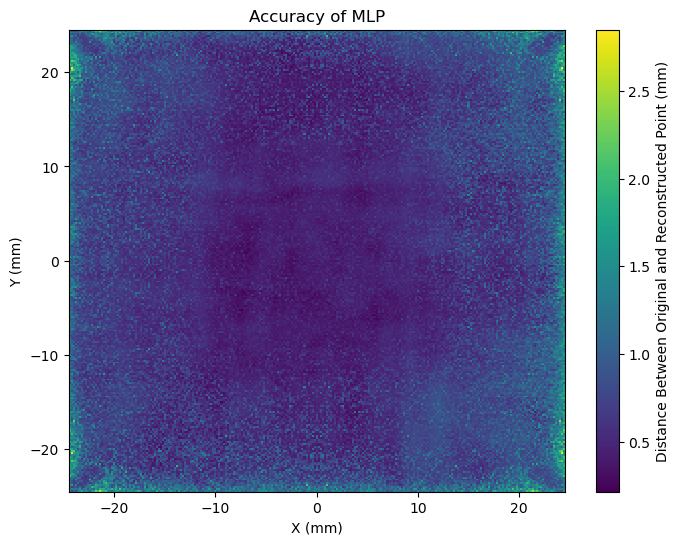

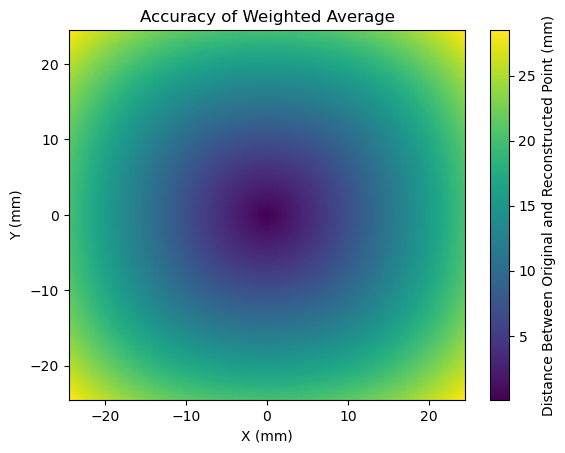

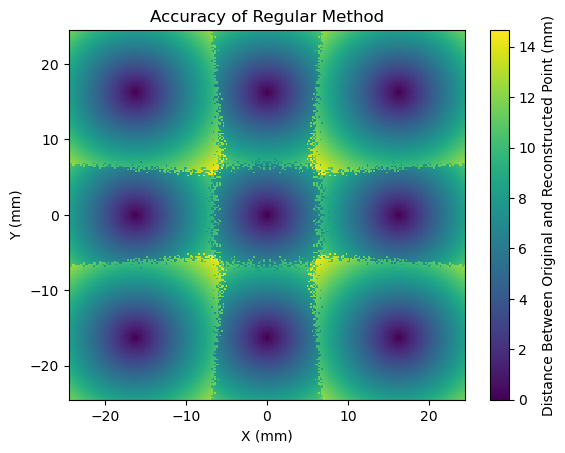

In [15]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_13mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.627721449529253
Median Regular Distance (mm): 6.615512073906297
Average Weighted Distance (mm): 14.73233739448905
Median Weighted Distance (mm): 15.259739917550288
Average MLP Distance (mm): 0.7244862343538421
Median MLP Distance (mm): 0.6433213711840693


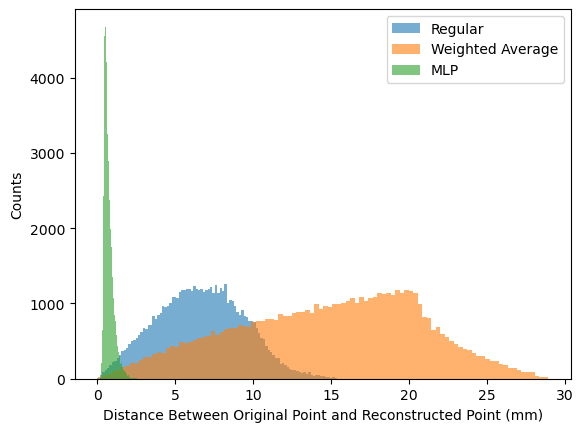

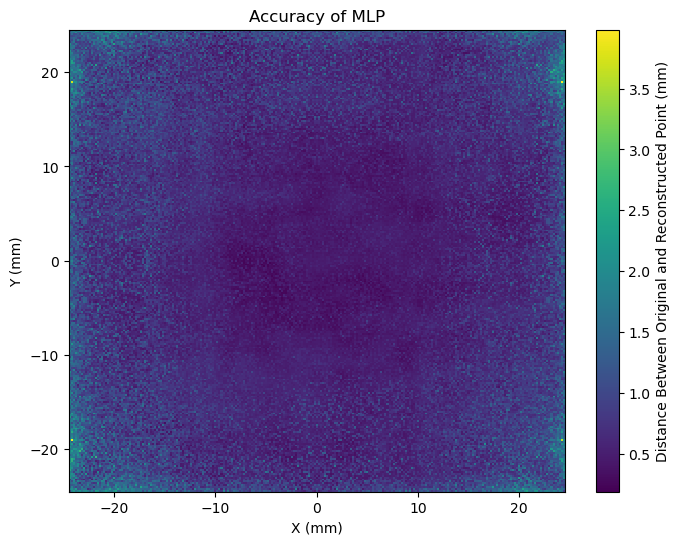

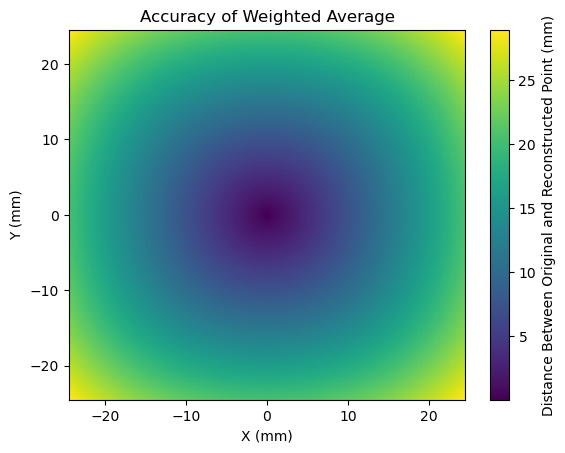

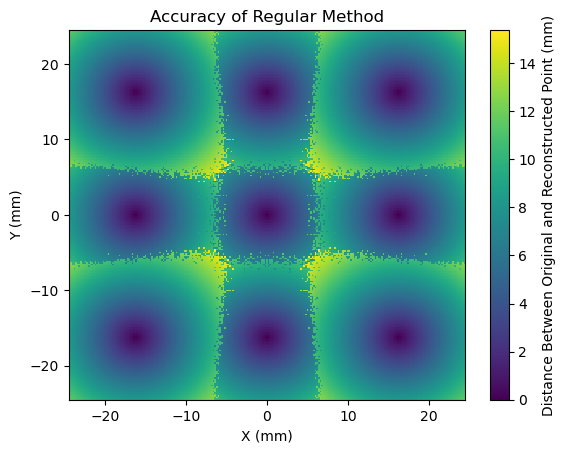

In [16]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_14mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 6.7142058298393765
Median Regular Distance (mm): 6.665208173793223
Average Weighted Distance (mm): 15.112599357544452
Median Weighted Distance (mm): 15.662182773328952
Average MLP Distance (mm): 0.7224072000534058
Median MLP Distance (mm): 0.6368840815736165


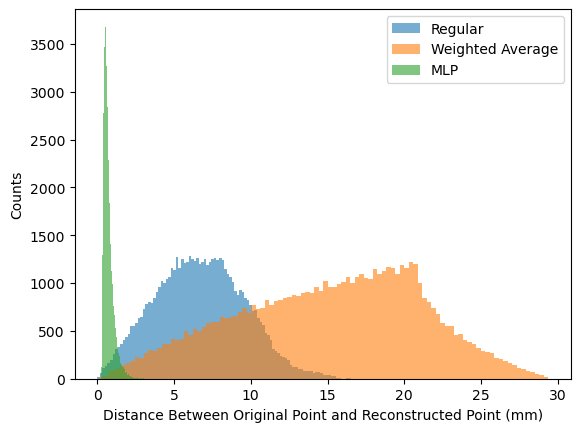

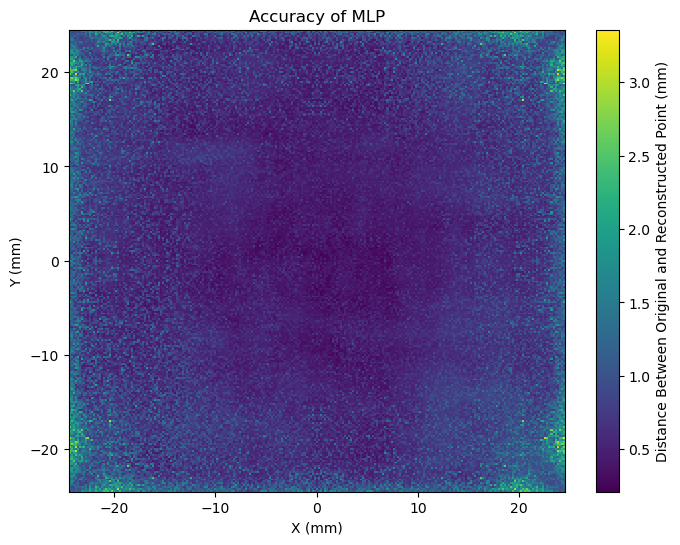

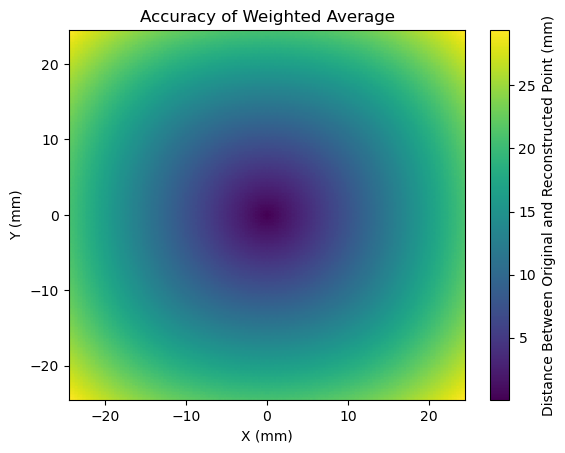

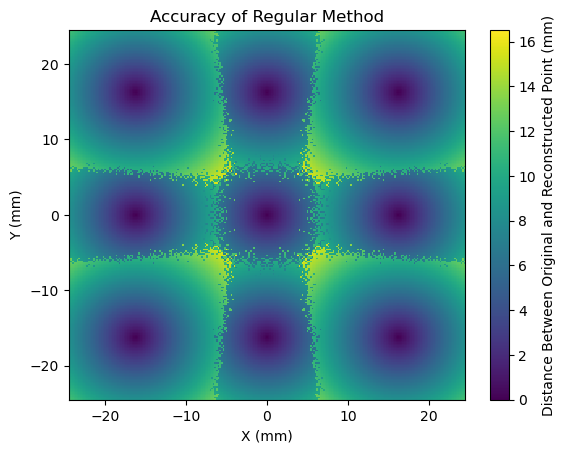

In [17]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_15mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 12.949328942910748
Median Regular Distance (mm): 12.560254774486065
Average Weighted Distance (mm): 17.53687628306085
Median Weighted Distance (mm): 18.25733941564192
Average MLP Distance (mm): 1.1122379014820962
Median MLP Distance (mm): 0.979734016715013


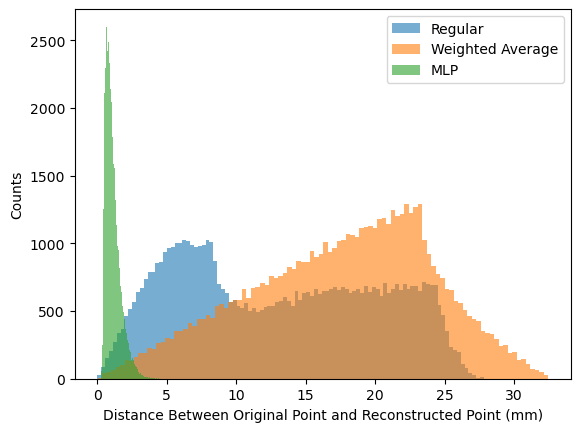

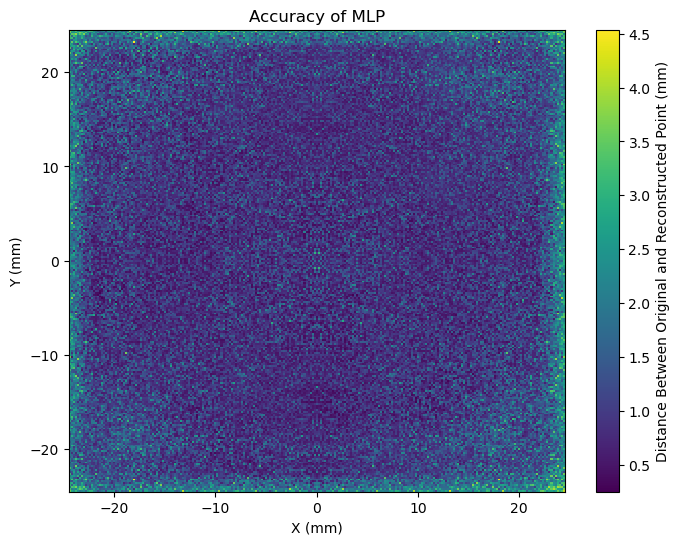

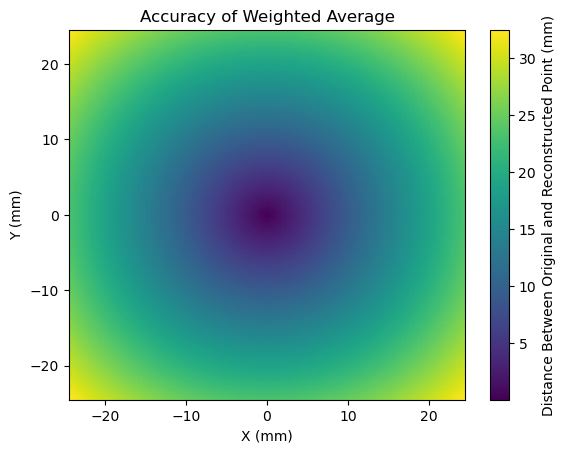

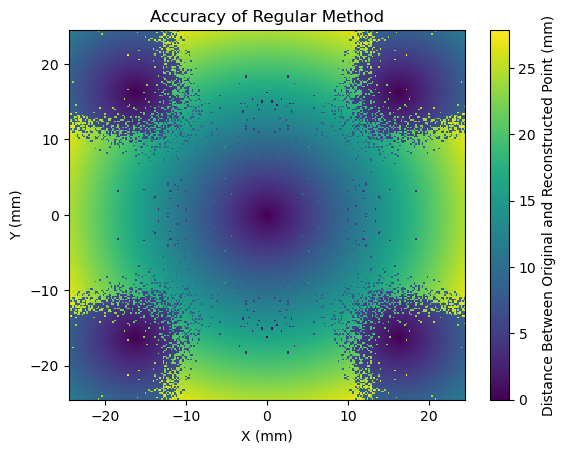

In [18]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_25mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

Average Regular Distance (mm): 18.746740404691632
Median Regular Distance (mm): 19.54788991170147
Average Weighted Distance (mm): 18.18277056863433
Median Weighted Distance (mm): 18.926064235745322
Average MLP Distance (mm): 2.7732721264326297
Median MLP Distance (mm): 2.1880133604043404


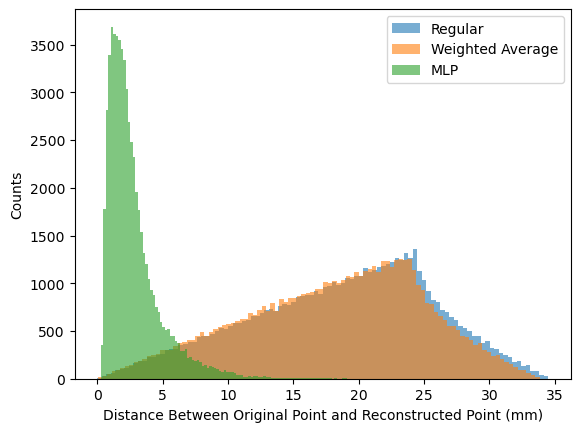

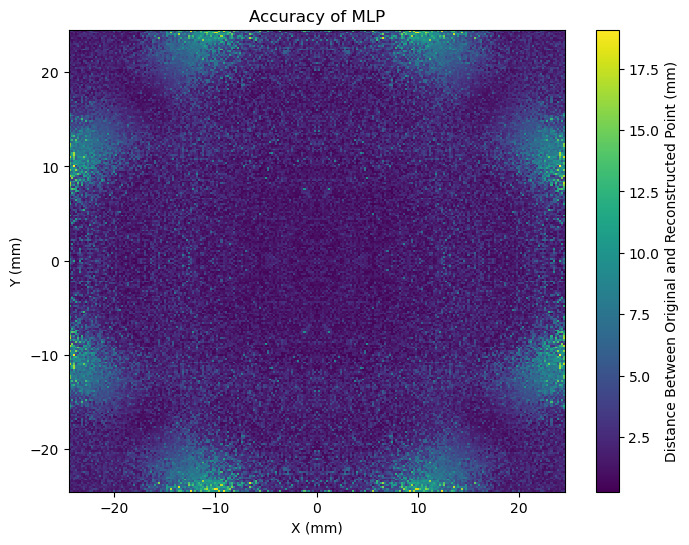

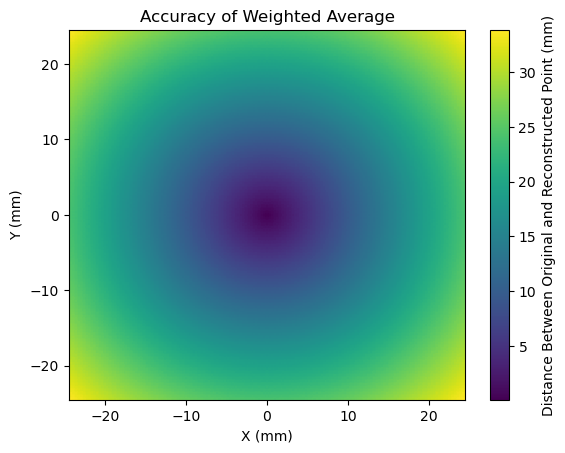

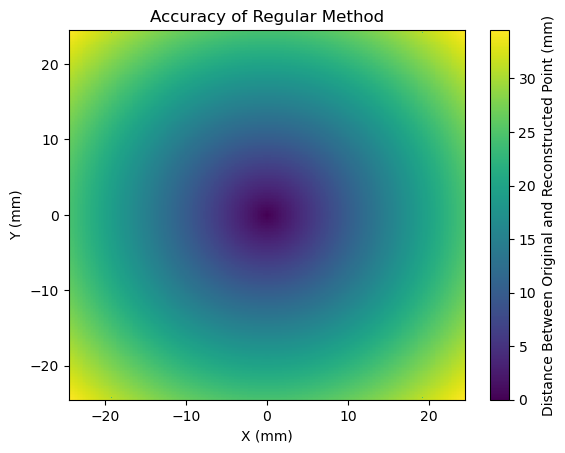

In [19]:
#getting X data
#file = open('/content/drive/MyDrive/output_nt_Hits_1_layer_5mm.csv')
file = open('/home/ni/Downloads/Geant4 Data/output_nt_Hits_45mm.csv')
csvreader = csv.reader(file)
#first 13 rows aren't needed
line_count = 0;
original_X = []
for row in csvreader:
  if line_count >= 13:
    original_X.append([int(i) for i in row])
  line_count += 1


#getting Y data
original_y = []
for i in range(-122, 1):
  for j in range(-122, 1):
    original_y.append([i*0.2, j*0.2])

#reconstructing
num_X = np.array(original_X).reshape(123,123,9)
num_y = np.array(original_y).reshape(123,123,2)
bottom_right_X = []
bottom_right_y = []
for i in range(-122, 0):
  for j in range(-122, 1):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    bottom_right_X.append(tmp_X)
    bottom_right_y.append(tmp_y)

bottom_right_X = np.array(bottom_right_X).reshape(122,123,9)
bottom_right_y = np.array(bottom_right_y).reshape(122,123,2)

top_left_X = []
top_left_y = []
for i in range(-122, 1):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(num_X[i+122][j+122])
    tmp_y = copy.deepcopy(num_y[i+122][j+122])
    #mirroring
    tmp_y[1] = -tmp_y[1]
    for k in range(3):
      tmp_X[k], tmp_X[k+3*2] = tmp_X[k+3*2], tmp_X[k]
    top_left_X.append(tmp_X)
    top_left_y.append(tmp_y)

top_left_X = np.array(top_left_X).reshape(123,122,9)
top_left_y = np.array(top_left_y).reshape(123,122,2)

top_right_X = []
top_right_y = []
for i in range(-122, 0):
  for j in range(-122, 0):
    tmp_X = copy.deepcopy(top_left_X[i+122][j+122])
    tmp_y = copy.deepcopy(top_left_y[i+122][j+122])
    #mirroring
    tmp_y[0] = -tmp_y[0]
    for k in range(3):
      tmp_X[3*k], tmp_X[3*k+2] = tmp_X[3*k+2], tmp_X[3*k]
    top_right_X.append(tmp_X)
    top_right_y.append(tmp_y)

top_right_X = np.array(top_right_X).reshape(122,122,9)
top_right_y = np.array(top_right_y).reshape(122,122,2)

#converting to numpy array
X = np.concatenate((num_X.reshape(15129, 9), bottom_right_X.reshape(15006, 9), top_left_X.reshape(15006, 9), top_right_X.reshape(14884, 9)))
y = np.concatenate((num_y.reshape(15129, 2), bottom_right_y.reshape(15006, 2), top_left_y.reshape(15006, 2), top_right_y.reshape(14884, 2)))

#closest detector
closest_distances = np.zeros((245,245))
for i in range(len(X)):
  maximum_value = np.argmax(X[i])
  if maximum_value == 0:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 16.25])
  elif maximum_value == 1:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 16.25])
  elif maximum_value == 2:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 16.25])
  elif maximum_value == 3:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, 0])
  elif maximum_value == 4:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, 0])
  elif maximum_value == 5:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, 0])
  elif maximum_value == 6:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [-16.25, -16.25])
  elif maximum_value == 7:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [0, -16.25])
  elif maximum_value == 8:
    closest_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist(y[i], [16.25, -16.25])

print("Average Regular Distance (mm): " + str(np.average(closest_distances)))
print("Median Regular Distance (mm): " + str(np.median(closest_distances)))

#weighted average
weighted_distances = np.zeros((245,245))
for i in range(len(X)):
  tmp = X[i]
  coord1 = (-24.4 * (tmp[0] + tmp[3] + tmp[6]) + 24.4 * (tmp[2] + tmp[5] + tmp[8])) / sum(tmp)
  coord2 = (24.4 * (tmp[0] + tmp[1] + tmp[2]) - 24.4 * (tmp[6] + tmp[7] + tmp[8])) / sum(tmp)
  # print([coord1, coord2])
  # print(ans)
  #finding
  weighted_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = math.dist([coord1, coord2], y[i])
print("Average Weighted Distance (mm): " + str(np.average(weighted_distances)))
print("Median Weighted Distance (mm): " + str(np.median(weighted_distances)))

#training
MLP_distances = np.zeros((245,245))
scaler = StandardScaler()
for k in range(10):
    X_MLP = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_MLP, y, test_size=0.3)

    model = Sequential()
    model.add(Dense(128, input_dim=9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')
 
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    #finding distances
    yhat = model.predict(X_MLP)
    for i in range(len(X)):
        #finding average of each point
        MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] = k / (k + 1) * MLP_distances[122+round(y[i][0]*5)][122-round(y[i][1]*5)] + 1 / (k + 1) * math.dist(yhat[i], y[i])

print("Average MLP Distance (mm): " + str(np.average(MLP_distances)))
print("Median MLP Distance (mm): " + str(np.median(MLP_distances)))

#histogram comparing all 3 methods
plt.hist(closest_distances.ravel(), bins=100, alpha=0.6, label='Regular')
plt.hist(weighted_distances.ravel(), bins=100, alpha=0.6, label='Weighted Average')
plt.hist(MLP_distances.ravel(), bins=100, alpha=0.6, label='MLP')
plt.xlabel('Distance Between Original Point and Reconstructed Point (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

#getting data setup for colormap for MLP
#yhat_temp = model.predict(X)
xaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
yaxis = 1000*np.linspace(-0.0244, 0.0244, 245)
#creating colormap
plt.figure(figsize=(8, 6))
plt.pcolormesh(xaxis, yaxis, MLP_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of MLP')

# Display the plot
plt.show()

#making colormap for weighted average
plt.pcolormesh(xaxis, yaxis, weighted_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Weighted Average')

# Display the plot
plt.show()

#making colormap for closest
plt.pcolormesh(xaxis, yaxis, closest_distances, shading='auto', cmap='viridis')

# Add color bar
plt.colorbar(label='Distance Between Original and Reconstructed Point (mm)')

# Add labels and title
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Accuracy of Regular Method')

# Display the plot
plt.show()

closest_distances_all_data.append(closest_distances)
weighted_distances_all_data.append(weighted_distances)
MLP_distances_all_data.append(MLP_distances)

In [32]:
closest_distances_all_data_np = np.array(closest_distances_all_data)
weighted_distances_all_data_np = np.array(weighted_distances_all_data)
MLP_distances_all_data_np = np.array(MLP_distances_all_data)

np.savetxt('closest_distances.csv', closest_distances_all_data_np.reshape(closest_distances_all_data_np.shape[0], -1))
np.savetxt('weighted_distances.csv', weighted_distances_all_data_np.reshape(weighted_distances_all_data_np.shape[0], -1))
np.savetxt('MLP_distances.csv', MLP_distances_all_data_np.reshape(MLP_distances_all_data_np.shape[0], -1))

#print(MLP_distances_all_data_np.shape)

In [37]:
loadedArr = np.loadtxt('closest_distances.csv')
loadedArr = loadedArr.reshape((-1, 245, 245))
print(loadedArr)
print(closest_distances_all_data_np)

[[[11.52584053 11.38529754 11.24655503 ... 11.24655503 11.38529754
   11.52584053]
  [11.38529754 11.24299782 11.1024772  ... 11.1024772  11.24299782
   11.38529754]
  [11.24655503 11.1024772  10.96015511 ... 10.96015511 11.1024772
   11.24655503]
  ...
  [11.24655503 11.1024772  10.96015511 ... 10.96015511 11.1024772
   11.24655503]
  [11.38529754 11.24299782 11.1024772  ... 11.1024772  11.24299782
   11.38529754]
  [11.52584053 11.38529754 11.24655503 ... 11.24655503 11.38529754
   11.52584053]]

 [[11.52584053 11.38529754 11.24655503 ... 11.24655503 11.38529754
   11.52584053]
  [11.38529754 11.24299782 11.1024772  ... 11.1024772  11.24299782
   11.38529754]
  [11.24655503 11.1024772  10.96015511 ... 10.96015511 11.1024772
   11.24655503]
  ...
  [11.24655503 11.1024772  10.96015511 ... 10.96015511 11.1024772
   11.24655503]
  [11.38529754 11.24299782 11.1024772  ... 11.1024772  11.24299782
   11.38529754]
  [11.52584053 11.38529754 11.24655503 ... 11.24655503 11.38529754
   11.5258